In [1]:
from ase.io import read
import numpy as np
from matplotlib import pyplot as plt
import joblib, pickle, sys
from castle import utils, LinearPotential, LPEnsemble, print_score, AceRepresentation, ASEMLCalculator

def split_dataset(N, training_percentage, seed=20):
    np.random.seed(seed)
    ids = list(range(N))
    np.random.shuffle(ids)
    return ids[:int(training_percentage*N)], ids[int(training_percentage*N):]

# Load structures

In [4]:
# Load xyz data
input_file =  "data/Si/delta_silicon.xyz"

frames_ = read(input_file, index = ':')
    
# Select only frames that contain virial information
frames = []
for ff in frames_:
    try:
        len(ff.info['dft_virial'])
        frames.append(ff)
    except KeyError:
        pass
    
energy_name = 'dft_energy'
force_name = 'dft_force'
virial_name = 'dft_virial'

# Build a model

Create representation

In [2]:
N = 5               # Number of products
maxdeg = 10         # Maximum degree of angular and radial expansion
rcut = 5.0          # Radial Cutoff
r0 = 1.0            # Lowest radius for basis
species = [14]      # Atomic Number of the elements present 
    
energy_name = 'dft_energy'
force_name = 'dft_force'
virial_name = 'dft_virial'
representation = AceRepresentation(N, maxdeg, rcut, 'Si', r0, energy_name=energy_name, force_name=force_name, virial_name=virial_name)

In [5]:
# Create training and validation set
tr_ind, val_ind = split_dataset(len(frames), 0.8)
tr_frames = [frames[s] for s in tr_ind]
val_frames = [frames[s] for s in val_ind]
e_t, f_t = utils.get_forces_and_energies(tr_frames, energy_name = energy_name, force_name = force_name)
e_val, f_val = utils.get_forces_and_energies(val_frames, energy_name = energy_name, force_name = force_name)
s_val = utils.get_virials(val_frames, virial_name)
nat_val = utils.get_nat(val_frames)

In [ ]:
# #  compute features
features = representation.transform(frames)
# #  save them
utils.dump(input_file[:-4] + "_features.xz", features)

## Train a linear model

In [9]:
# load the features
# features = load(input_file[:-4] + "_features.xz")
e_noise = 1e-8
f_noise = 1e-8
# get the subset of features for training
tr_features = features.get_subset(tr_ind)
# train the model
model_lin = LinearPotential(representation)
model_lin.fit_from_features(tr_features, e_t, f_t, e_noise, f_noise)

MAE=0.015 RMSE=0.031 SUP=0.227 R2=0.978
MAE=0.081 RMSE=0.132 SUP=2.328 R2=0.969


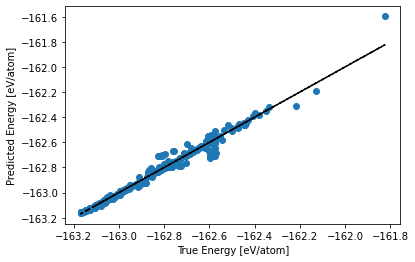

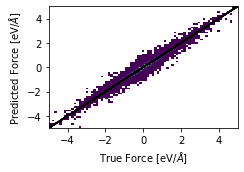

In [10]:
# evaluate its performances
val_features = features.get_subset(val_ind)
predictions = model_lin.predict_from_features(val_features, forces=True)
ep, fp = predictions['energy'], predictions['forces']
print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.figure(figsize = (3.5, 2.5))
plt.hist2d(np.ravel(f_val), np.ravel(fp), cmin = 1e-12, bins = 100, cmap = 'viridis')
plt.plot(f_val, f_val, 'k--')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.tight_layout()
plt.show()